In [1]:
using DifferentialEquations
using Plots

In [3]:
struct ThreeCompartmentParams
    # Capacitance (pF)
    C_s::Float64
    C_p::Float64
    C_d::Float64
    # Leak conductances (nS)
    gL_s::Float64
    gL_p::Float64
    gL_d::Float64
    # Reversal potentials (mV)
    EL_s::Float64
    EL_p::Float64
    EL_d::Float64
    # Coupling conductances (nS)
    g_sp::Float64
    g_pd::Float64
    # Calcium dynamics
    g_Ca::Float64
    E_Ca::Float64
    τ_m::Float64
    τ_h::Float64
    m_half::Float64
    h_half::Float64
    m_slope::Float64
    h_slope::Float64
    # Back-propagating AP (alpha current)
    τ_dAP::Float64
    J_dAP::Float64
    τ_pAP::Float64
    J_pAP::Float64
    # Adaptive threshold
    θ_base::Float64
    θ_jump::Float64
    τ_th::Float64
    # Spike dynamics
    V_peak::Float64
    V_reset::Float64
    t_ref::Float64
end

function alpha_current(t, t_spike, J, τ)
    t < t_spike ? 0.0 : J * (t - t_spike) / τ * exp(1 - (t - t_spike)/τ)
end

function calcium_inf(V, half, slope)
    1.0 / (1.0 + exp(slope * (V - half)))
end

function three_compartment_full!(du, u, p::ThreeCompartmentParams, t)
    Vd, Vp, Vs, m, h, θ, t_last_spike = u

    # Backpropagating AP currents
    I_dAP = alpha_current(t, t_last_spike + 2.0, p.J_dAP, p.τ_dAP)
    I_pAP = alpha_current(t, t_last_spike + 1.0, p.J_pAP, p.τ_pAP)

    # External input currents (can be modified later)
    I_s, I_p, I_d = 0.0, 0.0, 0.0

    # Calcium current in distal
    I_Ca = p.g_Ca * m * h * (p.E_Ca - Vd)

    # Distal
    du[1] = (
        -p.gL_d * (Vd - p.EL_d)
        - p.g_pd * (Vd - Vp)
        + I_Ca + I_dAP + I_d
    ) / p.C_d

    # Proximal
    du[2] = (
        -p.gL_p * (Vp - p.EL_p)
        - p.g_sp * (Vp - Vs)
        - p.g_pd * (Vp - Vd)
        + I_pAP + I_p
    ) / p.C_p

    # Soma
    gL_s_eff = (t - t_last_spike < p.t_ref) ? 150.0 : p.gL_s
    du[3] = (
        -gL_s_eff * (Vs - p.EL_s)
        - p.g_sp * (Vs - Vp)
        + I_s
    ) / p.C_s

    # Calcium dynamics
    m_inf = calcium_inf(Vd, p.m_half, p.m_slope)
    h_inf = calcium_inf(Vd, p.h_half, p.h_slope)
    du[4] = (m_inf - m) / p.τ_m
    du[5] = (h_inf - h) / p.τ_h

    # Adaptive threshold
    du[6] = (p.θ_base - θ) / p.τ_th

    # Dummy for spike time (don't integrate)
    du[7] = 0.0
end

# Callback for spike detection and reset
function spike_condition(u, t, integrator)
    Vs = u[3]
    θ = u[6]
    return Vs - θ
end

function spike_affect!(integrator)
    integrator.u[3] = integrator.p.V_peak      # spike peak
    integrator.u[6] += integrator.p.θ_jump     # adapt threshold
    integrator.u[7] = integrator.t             # update last spike time
end

spike_affect! (generic function with 1 method)

In [9]:
function run_three_compartment_euler(; T=100.0, dt=0.001, I_s=0.0, I_p=0.0, I_d=0.0)
    # 時間ベクトル
    tvec = 0.0:dt:T
    N = length(tvec)

    # パラメータ定義
    C_s, C_p, C_d = 100.0, 100.0, 100.0
    gL_s, gL_p, gL_d = 10.0, 10.0, 10.0
    EL_s, EL_p, EL_d = -70.0, -70.0, -70.0
    g_sp, g_pd = 5.0, 5.0

    # Calcium
    g_Ca, E_Ca = 10.0, 140.0
    τ_m, τ_h = 2.0, 40.0
    m_half, h_half = -21.0, -24.0
    m_slope, h_slope = 0.1, -0.1

    # Adaptive threshold
    θ_base, θ_jump, τ_th = -50.0, 20.0, 50.0
    V_peak, V_reset, t_ref = 30.0, -60.0, 2.0

    # Back-prop AP
    J_dAP, τ_dAP = 100.0, 1.0
    J_pAP, τ_pAP = 200.0, 1.0

    # 初期化
    Vd = fill(-70.0, N)
    Vp = fill(-70.0, N)
    Vs = fill(-70.0, N)
    m = fill(0.0, N)
    h = fill(1.0, N)
    θ = fill(θ_base, N)
    t_last_spike = -Inf
    spike_times = Float64[]

    for i in 1:N-1
        t = tvec[i]
        ref = (t - t_last_spike) < t_ref

        # alpha current (back-prop)
        Δt_dAP = t - (t_last_spike + 2.0)
        Δt_pAP = t - (t_last_spike + 1.0)
        I_dAP = Δt_dAP ≥ 0 ? J_dAP * (Δt_dAP/τ_dAP) * exp(1 - Δt_dAP/τ_dAP) : 0.0
        I_pAP = Δt_pAP ≥ 0 ? J_pAP * (Δt_pAP/τ_pAP) * exp(1 - Δt_pAP/τ_pAP) : 0.0

        # Calcium current
        m_inf = 1 / (1 + exp(m_slope * (Vd[i] - m_half)))
        h_inf = 1 / (1 + exp(h_slope * (Vd[i] - h_half)))
        I_Ca = g_Ca * m[i] * h[i] * (E_Ca - Vd[i])

        # Effective leak
        gL_s_eff = ref ? 150.0 : gL_s

        # Update variables with Euler method
        Vd[i+1] = Vd[i] + dt / C_d * (-gL_d*(Vd[i]-EL_d) - g_pd*(Vd[i]-Vp[i]) + I_Ca + I_dAP + I_d)
        Vp[i+1] = Vp[i] + dt / C_p * (-gL_p*(Vp[i]-EL_p) - g_sp*(Vp[i]-Vs[i]) - g_pd*(Vp[i]-Vd[i]) + I_pAP + I_p)
        Vs[i+1] = Vs[i] + dt / C_s * (-gL_s_eff*(Vs[i]-EL_s) - g_sp*(Vs[i]-Vp[i]) + I_s)

        m[i+1] = m[i] + dt * (m_inf - m[i]) / τ_m
        h[i+1] = h[i] + dt * (h_inf - h[i]) / τ_h
        θ[i+1] = θ[i] + dt * (θ_base - θ[i]) / τ_th

        # Spike detection
        if Vs[i+1] > θ[i+1] && !ref
            Vs[i+1] = V_peak
            θ[i+1] += θ_jump
            t_last_spike = t
            push!(spike_times, t)
        elseif Vs[i] == V_peak  # reset condition
            Vs[i+1] = V_reset
        end
    end

    return (tvec, Vd, Vp, Vs, spike_times)
end

run_three_compartment_euler (generic function with 1 method)

In [6]:
p = ThreeCompartmentParams(
    100.0, 100.0, 100.0,     # Capacitance
    10.0, 10.0, 10.0,        # Leak conductances
    -70.0, -70.0, -70.0,     # Leak potentials
    5.0, 5.0,                # Coupling conductance
    10.0, 140.0,             # Calcium conductance and reversal potential
    2.0, 40.0,               # τ_m, τ_h
    -21.0, -24.0,            # m_half, h_half
    0.1, -0.1,               # m_slope, h_slope
    1.0, 100.0,              # τ_dAP, J_dAP
    1.0, 200.0,              # τ_pAP, J_pAP
    -50.0, 20.0, 50.0,       # θ_base, θ_jump, τ_th
    30.0, -60.0, 2.0         # V_peak, V_reset, t_ref
)

u0 = [-70.0, -70.0, -70.0, 0.0, 1.0, p.θ_base, -100.0]  # Initial values
tspan = (0.0, 100.0)

(0.0, 100.0)

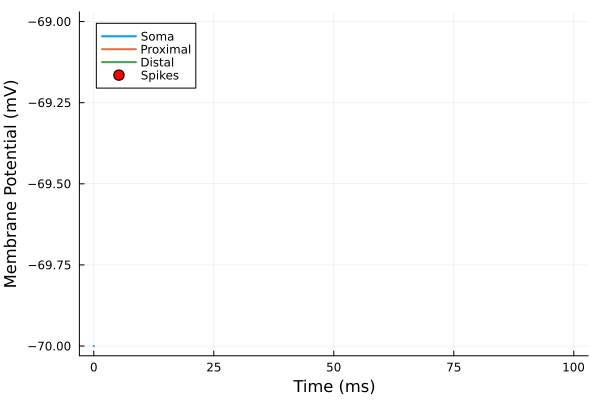

In [10]:
t, Vd, Vp, Vs, spk = run_three_compartment_euler()
plot(t, Vs, label="Soma", lw=2)
plot!(t, Vp, label="Proximal", lw=2)
plot!(t, Vd, label="Distal", lw=2)
scatter!(spk, fill(30.0, length(spk)), label="Spikes", color=:red)
xlabel!("Time (ms)")
ylabel!("Membrane Potential (mV)")

In [ ]:
plot(sol.t, sol[1,:], label="V_distal", color=:red)
plot!(sol.t, sol[2,:], label="V_proximal", color=:blue)
plot!(sol.t, sol[3,:], label="V_soma", color=:black)
plot!(xlabel="Time (ms)", ylabel="Membrane Potential (mV)", legend=:topright)